# Differentially Private Synthpop

## Generate synthetic data with DP-Synthpop

Based on the tiny Adult Dataset provided by the library of **dpart**

In [1]:
import sys

sys.path.append("..")

import pickle
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local packages
from generators.dpsynthpop_generator import DPSynthpopGenerator
from metrics.utility.application import Classification
from metrics.utility.population import Distinguishability
from metrics.utility.univariate import ContinuousConsistency

## Load the real data

In [2]:
df_real = {}
df_real["train"] = pd.read_pickle("../data/tiny_adult.pkl.gz")
df_real["test"] = pd.read_pickle("../data/tiny_adult_test.pkl.gz")

# Load bounds for each variable
with Path("../data/tiny_adult_bounds.pkl").open("rb") as fr:
    bounds = pickle.load(fr)

df_real["train"].shape

(32561, 6)

In [3]:
df_real["train"].columns

Index(['age', 'education', 'marital_status', 'relationship', 'sex', 'income'], dtype='object')

In [4]:
metadata = {
    "continuous": [
        "age",
    ],
    "categorical": [
        "education",
        "marital_status",
        "relationship",
        "sex",
        "income",
    ],
    "variable_to_predict": "income",
}

## Train the generator

In [5]:
gen = DPSynthpopGenerator(
    df=df_real["train"],
    metadata=metadata,
    generator_filepath=None,
    methods=None,
    epsilon={"dependency": 500, "methods": 500},
    slack=1.0,
    bounds=bounds,
    variables_order=None,
    prediction_matrix="infer",
    n_parents=None,
)

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gen.preprocess()
    gen.fit(save_path="../results/generators")  # the path should exist

In [7]:
gen.display()

Variable visit order:
   marital_status has parents []
   relationship has parents ['marital_status']
   age has parents ['marital_status', 'relationship']
   sex has parents ['marital_status', 'relationship', 'age']
   education has parents ['marital_status', 'relationship', 'age', 'sex']
   income has parents ['marital_status', 'relationship', 'age', 'sex', 'education']

Privacy budget spent:
(epsilon=1000.0000000000001, delta=1.0)


## Generate synthetic Data

In [8]:
df_synth = gen.sample(
    save_path="../results/data",  # the path should exist
    num_samples=len(df_real["train"]),
)

In [9]:
df_synth.head()

,age,education,marital_status,relationship,sex,income
0,38,HS-grad,Married-civ-spouse,Husband,Male,<=50K
1,33,HS-grad,Married-civ-spouse,Husband,Female,<=50K
2,20,7th-8th,Married-civ-spouse,Own-child,Male,<=50K
3,52,Bachelors,Never-married,Own-child,Female,>50K
4,69,Some-college,Separated,Not-in-family,Male,>50K


## Trade-off between privacy and utility

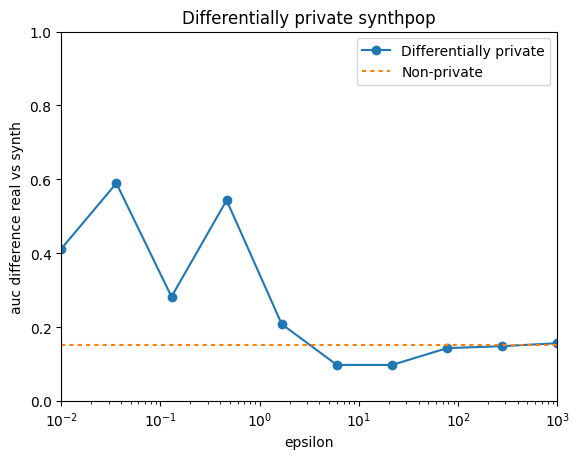

In [13]:
epsilons = list(np.logspace(-2, 3, 10))
epsilons.append(None)  # To also construct a non-private model for comparison
metrics = []

application = Classification(
    random_state=0,
    num_repeat=5,
    num_kfolds=5,
    num_optuna_trials=20,
    use_gpu=True,
)

# distinguishability = Distinguishability(
#     random_state=0,
#     num_repeat=5,
#     num_kfolds=5,
#     num_optuna_trials=20,
#     use_gpu=True,
# )

# continuousConsistency = ContinuousConsistency(random_state=0)


for epsilon in epsilons:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gen = DPSynthpopGenerator(
            df=df_real["train"],
            metadata=metadata,
            generator_filepath=None,
            methods=None,
            epsilon=epsilon,
            slack=0,
            bounds=bounds,
            variables_order=None,
            prediction_matrix="infer",
            n_parents=None,
        )

        gen.preprocess()
        gen.fit(save_path="../results/generators")

        df_synth = {}
        df_synth["train"] = gen.sample(
            save_path="../results/data",
            num_samples=len(df_real["train"]),
        )
        df_synth["test"] = gen.sample(
            save_path="../results/data",
            num_samples=len(df_real["test"]),
        )

        metric = application.compute(
            df_real=df_real, df_synthetic=df_synth, metadata=metadata
        )
        metrics.append(metric["average"]["diff_real_synth"])

        # metric = distinguishability.compute(
        #     df_real=df_real, df_synthetic=df_synth, metadata=metadata
        # )
        # metrics.append(metric["average"]["prediction_auc_rescaled"])

        # metric = continuousConsistency.compute(
        #     df_real=df_real, df_synthetic=df_synth, metadata=metadata
        # )
        # metrics.append(metric["average"]["within_ratio"])

plt.semilogx(epsilons[:-1], metrics[:-1], marker="o", label="Differentially private")
plt.plot(
    epsilons[:-1],
    np.ones_like(epsilons[:-1]) * metrics[-1],
    dashes=[2, 2],
    label="Non-private",
)
plt.title("Differentially private synthpop")
plt.xlabel("epsilon")
plt.ylabel("auc difference real vs synth")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-2])
plt.legend()
plt.show()